In [1]:
import sys
sys.path.append("/home/oldrain123/IMBALANCED_CLASSIFICATION/MOMs")
sys.path.append('/home/oldrain123/IMBALANCED_CLASSIFICATION/')

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from ctgan import CTGAN

from moms_generate import transform as moms_transform
from moms_losses import MMD_est_torch
from moms_visualize import visualize_samples
from moms_utils import set_seed
from gamosampler import GAMOtabularSampler  # Updated to include cTMU/IGU/LS loss per the paper
from mgvae import MGVAE

SEED = 1203
N_SAMPLES = 2000
N_MINORITY_SAMPLES = 100
NOISE = 0.25
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

set_seed(SEED)

def generate_half_moon_data(n_total, n_min_subsample, noise, seed):
    X, y = make_moons(n_samples=n_total, noise=noise, random_state=seed)
    X_maj = X[y == 0]
    X_min = X[y == 1]
    subsample_indices = np.random.choice(X_min.shape[0], n_min_subsample, replace=False)
    X_min_sub = X_min[subsample_indices]
    return X_maj, X_min_sub

def run_ctgan_oversampling(X_min, n_samples_to_gen):
    X_min_df = pd.DataFrame(X_min, columns=['f1', 'f2'])
    ctgan = CTGAN(epochs=2000, embedding_dim=16, generator_dim=(32, 64), verbose=False)
    ctgan.fit(X_min_df)
    return ctgan.sample(n_samples_to_gen).values

def run_mgvae_oversampling(
    X_maj,
    X_min,
    n_samples_to_gen,
    device,
    latent_dim=128,
    hidden_dims=[64],
    majority_subsample=None,
    pretrain_epochs=0,
    finetune_epochs=100,
    pretrain_batch_size=1000,
    finetune_batch_size=4,
    lr=1e-3,
    ewc_lambda=0.01
):
    # -- prepare tensors
    X_maj_t = torch.tensor(X_maj, dtype=torch.float32, device=device)
    X_min_t = torch.tensor(X_min, dtype=torch.float32, device=device)

    D = X_maj.shape[1]
    majority_sub = majority_subsample or X_maj.shape[0]

    # -- build model
    model = MGVAE(
        input_dim=D,
        latent_dim=latent_dim,
        hidden_dims=hidden_dims,
        device=device,
        majority_subsample=majority_sub
    )

    # -- two-stage training
    model.fit(
        X_maj_t,
        X_min_t,
        pretrain_epochs=pretrain_epochs,
        finetune_epochs=finetune_epochs,
        batch_size=pretrain_batch_size,
        lr=lr,
        ewc_lambda=ewc_lambda
    )

    # -- generate
    samples = model.sample(X_maj_t, n_samples=n_samples_to_gen)
    return samples



def run_gamo_oversampling(X_maj, X_min, n_samples_to_gen, device):
    # Reconstructed in a manner faithful to the original GAMO
    input_dim = X_min.shape[1]
    n_classes = 2
    class_counts = [len(X_maj), len(X_min)]
    all_minority_X = {0: X_maj, 1: X_min}
    # Only class 1 (minority) generator is relevant in binary half-moon
    sampler = GAMOtabularSampler(
        input_dim=input_dim,
        latent_dim=2,
        hidden_dim=32,
        n_classes=n_classes,
        class_counts=class_counts,
        all_minority_X=all_minority_X,
        device=device
    )
    # Only class 1 instances need be provided; method signature may differ for multi-class
    class_X_dict = {0: X_maj, 1: X_min}
    sampler.fit(class_X_dict, n_epochs=1000, lr=1e-3, seed=SEED)
    return sampler.sample(n_samples=n_samples_to_gen, class_id=1)

/home/oldrain123/anaconda3/envs/imb_clf/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


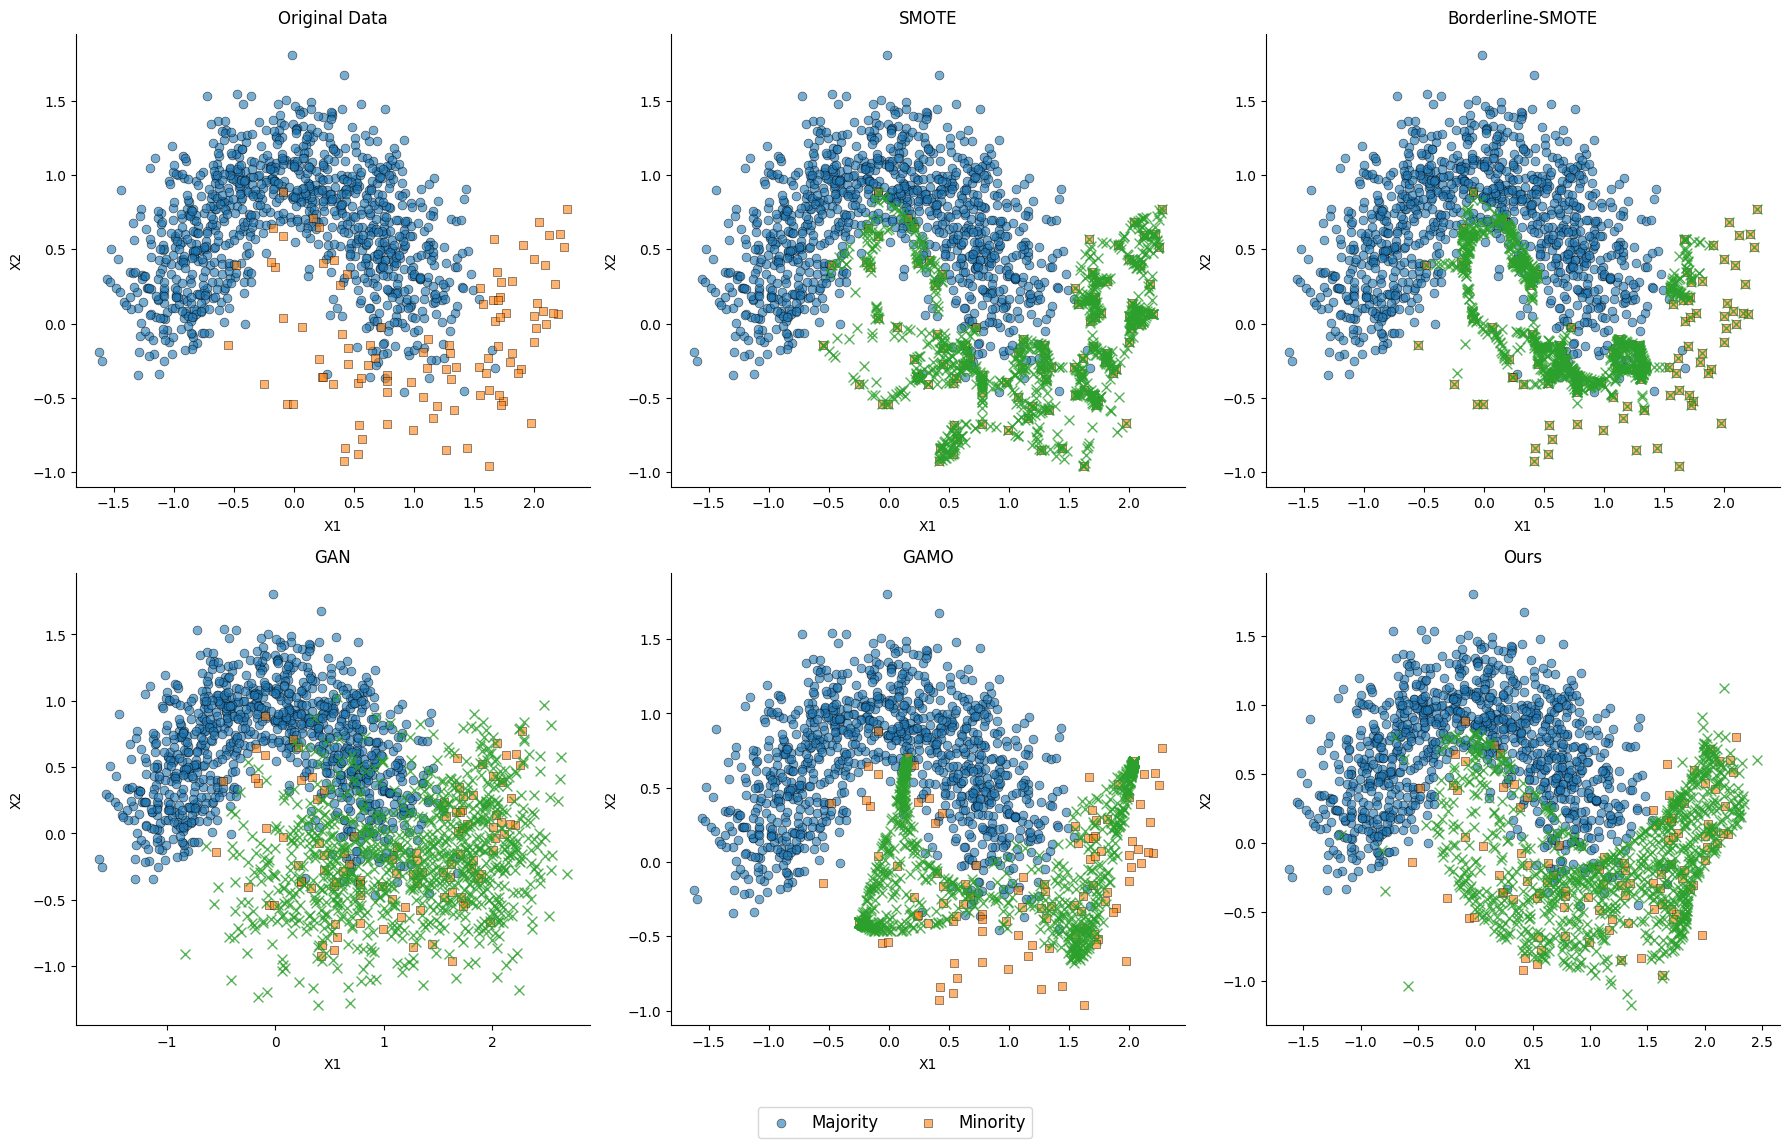

In [3]:
if __name__ == "__main__":
    X_maj, X_min = generate_half_moon_data(N_SAMPLES, N_MINORITY_SAMPLES, NOISE, SEED)
    n_samples_to_generate = X_maj.shape[0] - X_min.shape[0]
    oversamplers = {
        'SMOTE': lambda: SMOTE(random_state=SEED).fit_resample(
            np.vstack([X_maj, X_min]),
            np.hstack([np.zeros(len(X_maj)), np.ones(len(X_min))])
        )[0][len(X_maj):],
        'Borderline-SMOTE': lambda: BorderlineSMOTE(random_state=SEED).fit_resample(
            np.vstack([X_maj, X_min]),
            np.hstack([np.zeros(len(X_maj)), np.ones(len(X_min))])
        )[0][len(X_maj):],
        'GAN': lambda: run_ctgan_oversampling(X_min, n_samples_to_generate),
        'GAMO': lambda: run_gamo_oversampling(X_maj, X_min, n_samples_to_generate, DEVICE),
        # 'MGVAE': lambda: run_mgvae_oversampling(X_maj, X_min, n_samples_to_generate, DEVICE),
        'Ours': lambda: moms_transform(
            X_maj=X_maj, X_min=X_min, in_dim=2, hidden_dims=[64, 128], latent_dim=32,
            loss_fn=MMD_est_torch, kernel_type='gaussian', device=DEVICE, n_epochs=2000,
            lr=1e-3, beta=0.001, seed=SEED)[2]
    }

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    visualize_samples(axes[0], X_maj, X_min, np.array([]), title="Original Data")
    for i, (name, sampler_fn) in enumerate(oversamplers.items(), 1):
        X_generated = sampler_fn()
        visualize_samples(axes[i], X_maj, X_min, X_generated, title=name)
    for j in range(len(oversamplers) + 1, len(axes)):
        axes[j].axis('off')

    # 전체 범례 한 번만 생성
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels,
               loc='lower center',
               ncol=len(labels),
               frameon=True,
               fontsize=12,
               bbox_to_anchor=(0.5, 0.00))

    plt.tight_layout(rect=[0, 0.05, 1, 0.96])
    # PDF로 저장
    plt.savefig("halfmoon_synthetic_experiment.pdf",
                dpi=400,
                format='pdf',
                bbox_inches='tight')
    plt.show()


In [4]:
X_maj, X_min = generate_half_moon_data(N_SAMPLES, N_MINORITY_SAMPLES, NOISE, SEED)
n_samples_to_generate = X_maj.shape[0] - X_min.shape[0]

In [5]:
device= 'cuda'
X_maj_tensor = torch.tensor(X_maj, dtype=torch.float32).to(device)
X_min_tensor = torch.tensor(X_min, dtype=torch.float32).to(device)
model = MGVAE(input_dim=2, latent_dim=16, hidden_dims=[32, 64], device=device, majority_subsample=1000)
model.pretrain(X_maj_tensor, epochs=500, lr=1e-2)
# pretrain_params = {n: p.clone().detach() for n, p in model.named_parameters()}
# fisher_info = model.compute_fisher(X_maj_tensor)
# model.finetune(X_min_tensor, X_maj_tensor, fisher_info, pretrain_params, epochs=100, lr=1e-3, ewc_lambda=0.0)

In [6]:
pretrain_params = {n: p.clone().detach() for n, p in model.named_parameters()}

In [7]:
fisher_info = model.compute_fisher(X_maj_tensor, batch_size = 100)

In [8]:
fisher_info

{'encoder.encoder.0.weight': tensor([[1.4695e-05, 1.0238e-05],
         [4.2946e-06, 9.5546e-06],
         [4.0195e-05, 4.3694e-05],
         [1.2024e-05, 1.0483e-05],
         [4.5137e-05, 1.8979e-04],
         [5.6572e-06, 5.5882e-06],
         [1.6845e-05, 1.0271e-05],
         [6.9771e-06, 6.6774e-06],
         [2.5112e-04, 2.3336e-05],
         [8.0728e-05, 2.2339e-04],
         [3.2467e-05, 2.7609e-05],
         [3.7938e-06, 1.3883e-06],
         [2.8826e-05, 3.1197e-05],
         [1.2360e-05, 9.2877e-06],
         [5.1160e-05, 4.5643e-05],
         [2.5773e-05, 3.1701e-05],
         [5.7550e-05, 2.6487e-05],
         [2.3446e-05, 1.2849e-04],
         [3.9582e-05, 2.2256e-05],
         [5.6342e-06, 4.9196e-06],
         [2.7507e-05, 1.0241e-05],
         [8.2397e-06, 1.4350e-05],
         [1.2594e-05, 1.2549e-05],
         [1.1377e-05, 1.1080e-05],
         [3.5476e-05, 2.5944e-05],
         [8.6856e-06, 8.2639e-06],
         [2.3487e-05, 1.6061e-05],
         [6.7988e-06, 6.840

In [9]:
# 'Ours': lambda: moms_transform(
        #     X_maj=X_maj, X_min=X_min, in_dim=2, hidden_dims=[64, 128], latent_dim=32,
        #     loss_fn=MMD_est_torch, kernel_type='gaussian', device=DEVICE, n_epochs=2000, # [6]
        #     lr=1e-3, beta=0.01, seed=SEED)[2] # [8]